## Mestrado em Ciência de Dados - Projeto de Big Data
### **Predição do Sucesso de Campanhas de Marketing**
#### Trabalho realizado por Tiago Ribeiro e Valter Bento
#### 13 de Janeiro de 2023

---

>**Objeto de estudo**: prever o sucesso de campanha de telemarketing para vender depósitos a prazo \\
>**Ponto de partida**: dados recolhidos por um banco português de 2008 a 2013

---

## Instalacões e Configuracões para execucão do **PySpark** no Colab




###**Método 1**

```python
# Descarrega JAVA 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Descarrega Spark-Hadoop 
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz    
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
# Instala findspark 
!pip install -q findspark
# Cria variáveis ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"
import findspark          
findspark.init()  # Localiza Spark e permite utilizar PySpark como biblioteca regular 
```

###**Método2**

In [ ]:
!pip install -q pyspark  # simplesmente

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.3 MB/s eta 0:00:00


## Bibliotecas

In [ ]:
# - Bibliotecas de Uso Geral ---------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
# - PySpark Utilitários --------------------------------------------------------
import pyspark.sql.functions as pyf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan
from pyspark.sql.functions import when
from pyspark.sql.functions import count
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
from pyspark.sql.functions import round
# - Transformacões e Pipeline --------------------------------------------------
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
# - Modelos PySpark ------------------------------------------------------------
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
# - Avaliacão e Parametrizacão dos Modelos ------------------------------------
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
sns.set(style="whitegrid")

## Criação da Spark Session

In [ ]:
spark = SparkSession.builder.appName("bigdata-project").getOrCreate()

In [ ]:
spark

## 1. Carregamento do Conjunto de Dados

**Linguagem de comandos `Bash`**

```shell 
hdfs dfs -mkdir -p /user/projeto_big_data                # cria diretório DFS
hdfs dfs -copyFromLocal bank.csv /user/projeto_big_data  # copia ficheiro dataset para DFS
rm -rf ~/hadoop-3.3.4/dfs      # na primeira execucão, remove DataNodes antigos
hdfs namenode -format          # formata NameNode 
start-dfs.sh                   # inicia daemons DFS Hadoop, o namenode e os datanodes
start-yarn.sh                  # inicia o YARN "Yet Again Another Resouce Negociator"
jps                            # consulta Status do processo JAVA (Sanity Check)
#mv metastore_db metastore_db.tmp    # caso ocorra: Error: FUNCTION 'NUCLEUS_ASCII' already exists.
schematool -initSchema -dbType derby  # inicializa base de dados MetaStore (na primeira execucão)
hive                                  # inicia terminal Hive 
```


**Linguagem de comandos `Hive`** 

```mysql
# Cria tabela bank_csv
CREATE TABLE IF NOT EXISTS bank_csv (
    age TINYINT,
    job STRING,
    marital STRING,
    education STRING,
    default CHAR(10),
    balance FLOAT,
    housing CHAR(3),
    loan CHAR(3),
    contact CHAR(10),
    day TINYINT,
    month CHAR(10),
    duration INT,
    campaign SMALLINT,
    pdays INT,
    previous INT,
    outcome CHAR(10),
    deposit CHAR(3)
    )
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE;

# carrega dados do ficheiro bank.csv para tabele bank_csv
LOAD DATA LOCAL INPATH "bank.csv" INTO TABLE bank_csv;
```
**Linguagem `Python`** 
```python
from pyspark.sql import SparkSession

spark = SparkSession.builder \
            .master("local[*]") \ 
            .appName("spark") \
            .config("spark.sql.warehouse.dir", "warehouse") \
            .enableHiveSupport() \
            .getOrCreate()

spark.sql("show tables").show() 

df = spark_hive.sql("SELECT * FROM bank_csv;")
```

In [ ]:
# Descarrega Conjunto de Dados
!wget -q  "https://www.dropbox.com/s/be4zh42xlxfr5qs/bank.csv?dl=1"

In [ ]:
df = spark.read.csv("bank.csv?dl=1", header = True, inferSchema = True)

In [ ]:
# df = df_all.na.drop(how="any")
# print(df_all.count(), df.count())

## 2. Exploração dos Dados

### 2.1 Formato (esquema) e Colunas do conjunto de dados

In [ ]:
df.show(10)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.| married| tertiary|     no|    184|     no|  no|unkno

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#### 2.1.1 Numero de linhas/registos e colunas/variáveis 

In [ ]:
print(f"Total de linhas: {df.count()}\nTotal de colunas: {len(df.columns)}")

Total de linhas: 11162
Total de colunas: 17


### 2.2 Dicionário de Dados

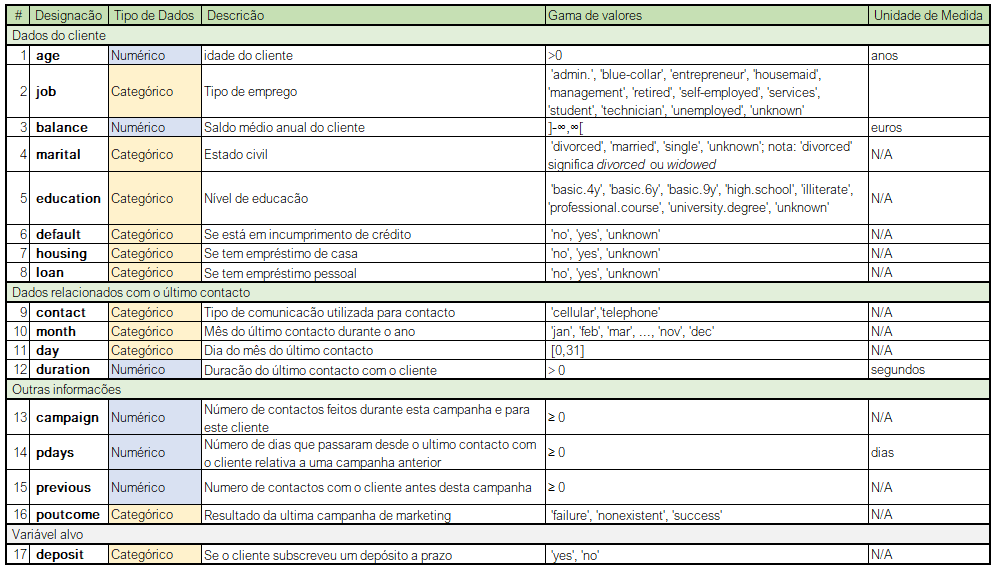

### 2.3 Balanceamento e Variável Alvo *deposit*





In [ ]:
df_dep = df.groupby("deposit").count()
df_dep = df_dep.withColumn('percentage', 
                           round(df_dep['count']/df.count()*100, 2)).show()

+-------+-----+----------+
|deposit|count|percentage|
+-------+-----+----------+
|     no| 5873|     52.62|
|    yes| 5289|     47.38|
+-------+-----+----------+



### 2.4 Dados Omissos

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



### 2.5 Dados Duplicados

In [ ]:
df.groupBy(df.columns).count().filter("count > 1").show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+-----+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|count|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+-----+
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+-----+



### 2.6. Análise de Variáveis 

#### 2.6.1 Variáveis Númericas

In [ ]:
cols_qtt = ["age", "balance", "duration", "day", "campaign", "pdays", "previous"]

##### Age

In [ ]:
df_summary = df.select("age", "balance").summary().show()

+-------+------------------+------------------+
|summary|               age|           balance|
+-------+------------------+------------------+
|  count|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|
| stddev|11.913369192215518| 3225.413325946149|
|    min|                18|             -6847|
|    25%|                32|               122|
|    50%|                39|               550|
|    75%|                49|              1708|
|    max|                95|             81204|
+-------+------------------+------------------+



In [ ]:
df_pd = df.toPandas()  # converte data frame Spark em data frame Pandas

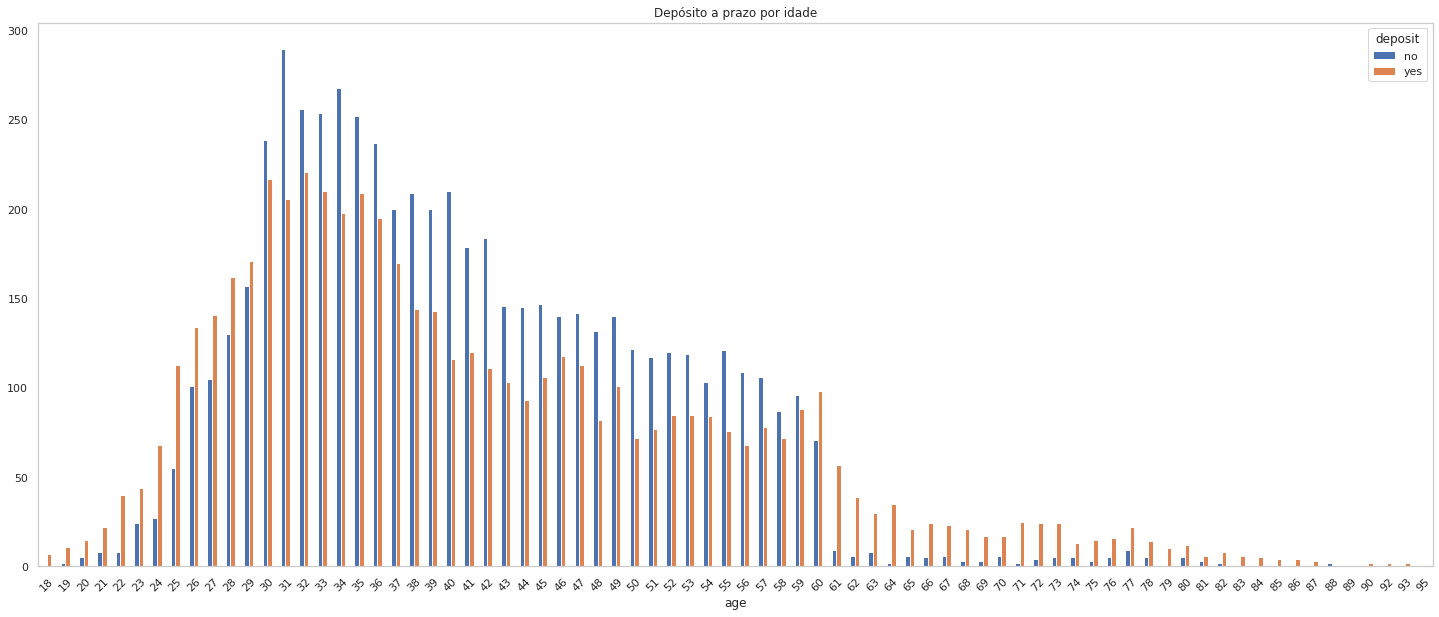

In [ ]:
age_gb = df_pd.groupby(['age','deposit']).size().unstack()
ax = age_gb.plot.bar(rot=45, figsize=(25, 10), grid = False, title = 'Depósito a prazo por idade')

In [ ]:
df_dep_yes = df_pd[df_pd['deposit'] == 'yes']
df_dep_no = df_pd[df_pd['deposit'] == 'no']

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


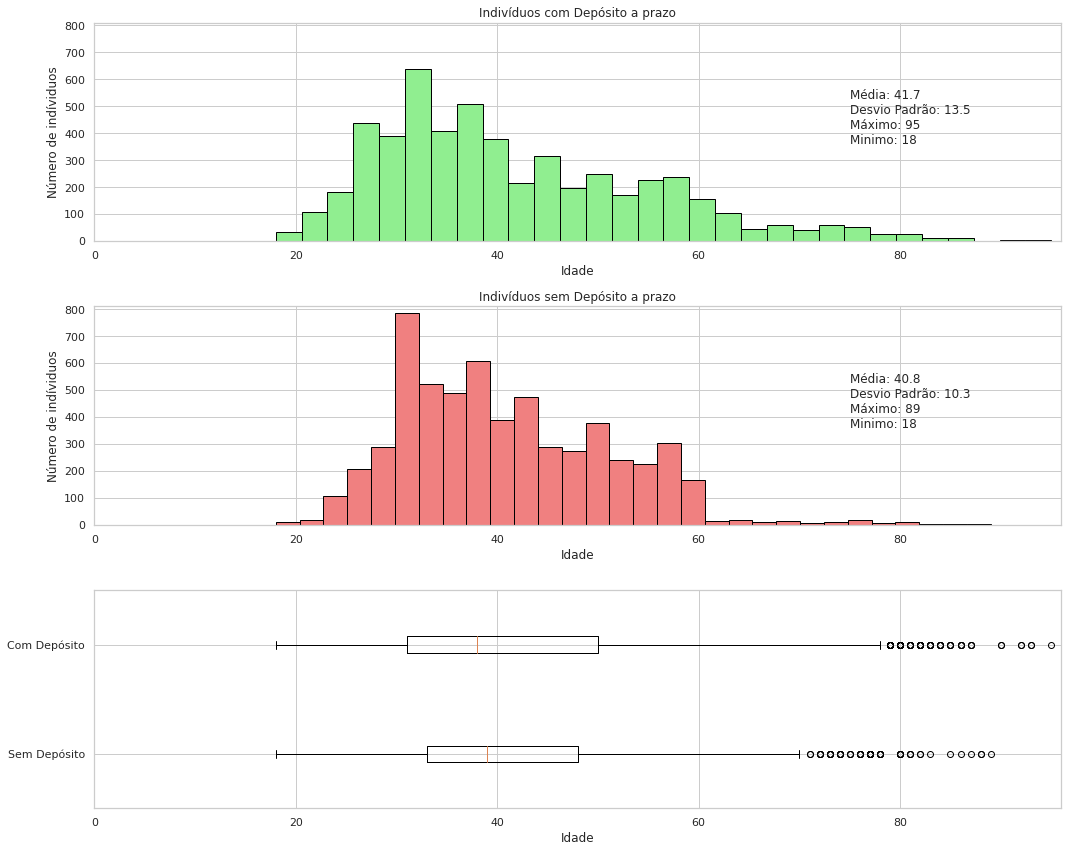

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))

ax1.hist(df_dep_yes['age'], 30, edgecolor='black', color = "lightgreen")
media1 = np.round(df_dep_yes['age'].mean(axis=0), 1)
dp1 = np.round(df_dep_yes['age'].std(axis=0),1)
max1 = np.round(df_dep_yes['age'].max(axis=0),1)
min1 = np.round(df_dep_yes['age'].min(axis=0),1)
texto = f'Média: {media1}\nDesvio Padrão: {dp1}\nMáximo: {max1}\nMinimo: {min1}'
ax1.text(x = max1-20, y = 350, s = texto, verticalalignment='bottom')
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set(xlabel='Idade', ylabel = 'Número de indíviduos')
ax1.set_ylim(0, 810)
ax1.set_xlim(0, 96)

ax2.hist(df_dep_no['age'], 30, edgecolor='black', color = "lightcoral")
media2 = np.round(df_dep_no['age'].mean(axis=0), 1)
dp2 = np.round(df_dep_no['age'].std(axis=0),1)
max2 = np.round(df_dep_no['age'].max(axis=0),1)
min2 = np.round(df_dep_no['age'].min(axis=0),1)
texto = f'Média: {media2}\nDesvio Padrão: {dp2}\nMáximo: {max2}\nMinimo: {min2} '
ax2.text(x = max1-20, y = 350, s = texto, verticalalignment='bottom')
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set(xlabel='Idade', ylabel = 'Número de indíviduos')
ax2.set_ylim(0, 810)
ax2.set_xlim(0, 96)

ax3.boxplot([df_dep_no['age'],df_dep_yes['age']], vert = False)
ax3.set(xlabel='Idade')
ax3.set_xlim(0, 96)
ax3.set_yticklabels(['Sem Depósito', 'Com Depósito'])

plt.tight_layout()

##### Balance

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


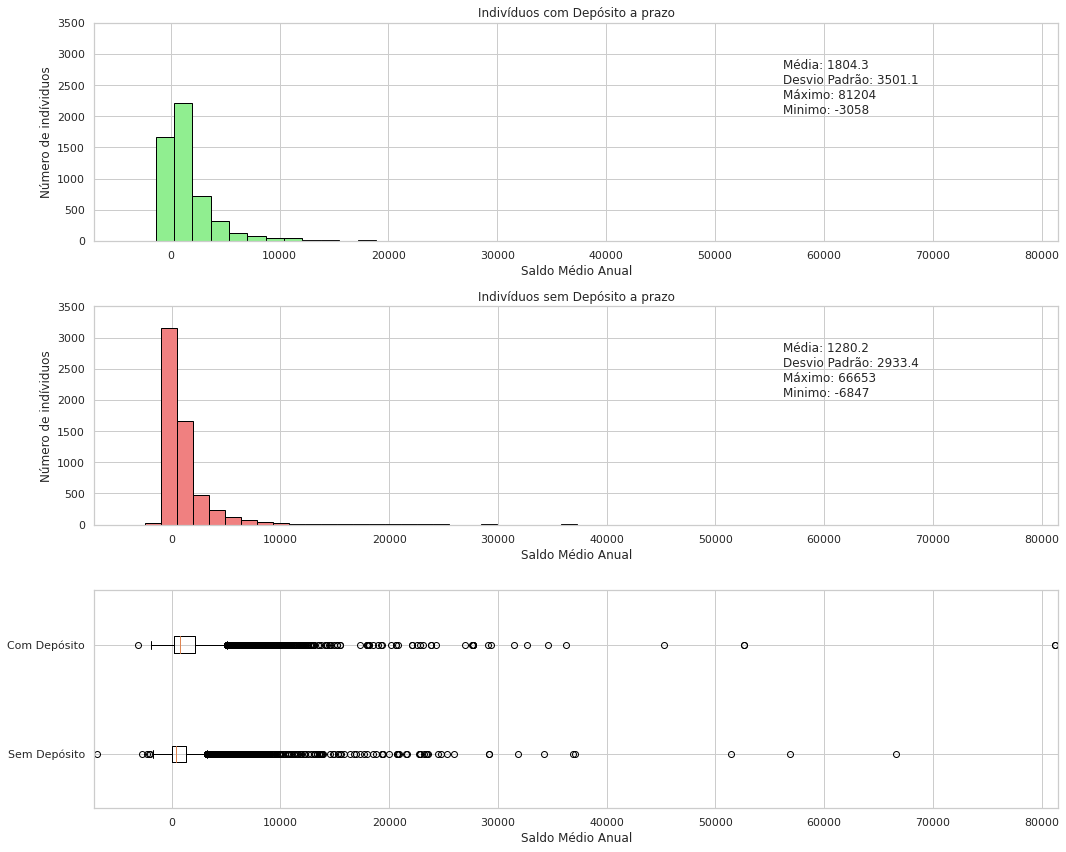

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))

ax1.hist(df_dep_yes['balance'], 50, edgecolor='black', color = "lightgreen")
media1 = np.round(df_dep_yes['balance'].mean(axis=0), 1)
dp1 = np.round(df_dep_yes['balance'].std(axis=0),1)
max1 = np.round(df_dep_yes['balance'].max(axis=0),1)
min1 = np.round(df_dep_yes['balance'].min(axis=0),1)
texto = f'Média: {media1}\nDesvio Padrão: {dp1}\nMáximo: {max1}\nMinimo: {min1}'
ax1.text(x = max1-25000, y = 2000, s = texto, verticalalignment='bottom')
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set(xlabel='Saldo Médio Anual', ylabel = 'Número de indíviduos')
ax1.set_ylim(0, 3500)
ax1.set_xlim(-7000, 81500)

ax2.hist(df_dep_no['balance'], 50, edgecolor='black', color = "lightcoral")
media2 = np.round(df_dep_no['balance'].mean(axis=0), 1)
dp2 = np.round(df_dep_no['balance'].std(axis=0),1)
max2 = np.round(df_dep_no['balance'].max(axis=0),1)
min2 = np.round(df_dep_no['balance'].min(axis=0),1)
texto = f'Média: {media2}\nDesvio Padrão: {dp2}\nMáximo: {max2}\nMinimo: {min2} '
ax2.text(x = max1-25000, y = 2000, s = texto, verticalalignment='bottom')
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set(xlabel='Saldo Médio Anual', ylabel = 'Número de indíviduos')
ax2.set_ylim(0, 3500)
ax2.set_xlim(-7100, 81500)

ax3.boxplot([df_dep_no['balance'],df_dep_yes['balance']], vert = False)
ax3.set(xlabel='Saldo Médio Anual')
ax3.set_xlim(-7100, 81500)
ax3.set_yticklabels(['Sem Depósito', 'Com Depósito'])

plt.tight_layout()

##### Previous

In [ ]:
df.select("day", "duration", "campaign", "pdays", "previous").summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|
|   mean|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                 1|                 2|                 1|                -1|                 0|
|    25%|                 8|               138|                 1|                -1|                 0|
|    50%|                15|               255|                 2|                -1|                 0|
|    75%|                22|               496|        

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


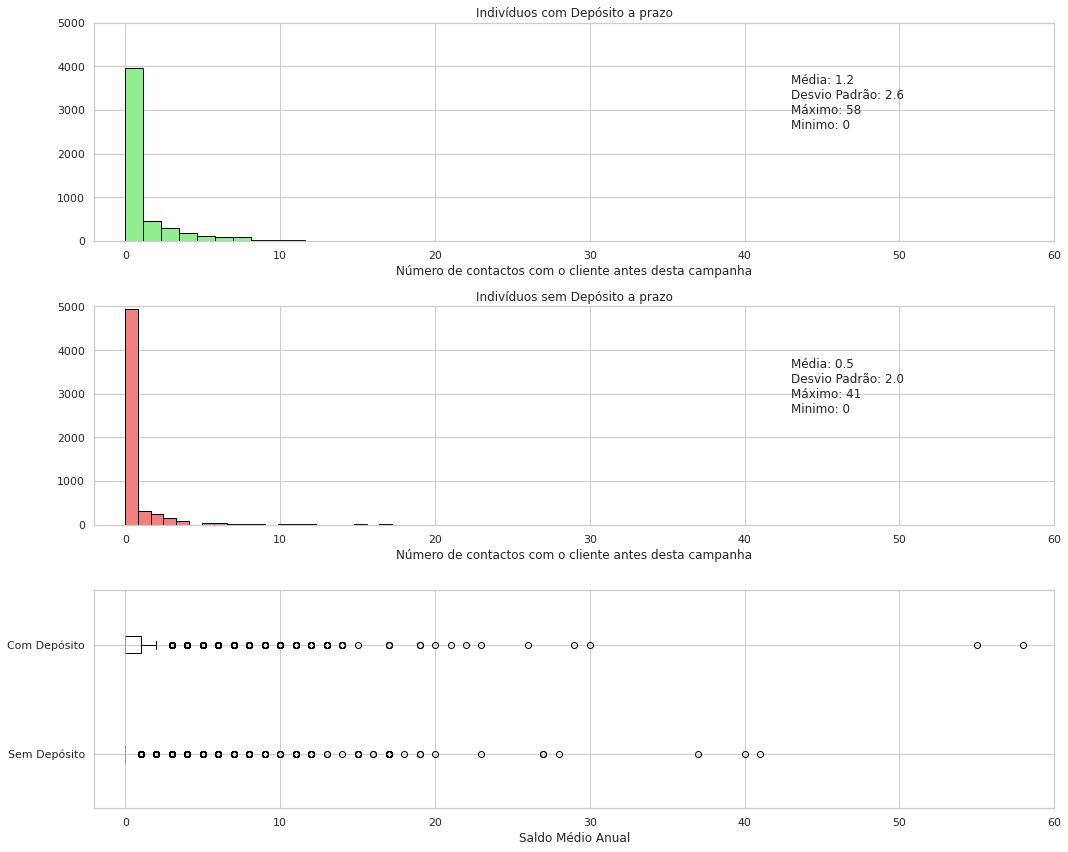

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))

ax1.hist(df_dep_yes['previous'], 50, edgecolor='black', color = "lightgreen")
media1 = np.round(df_dep_yes['previous'].mean(axis=0), 1)
dp1 = np.round(df_dep_yes['previous'].std(axis=0),1)
max1 = np.round(df_dep_yes['previous'].max(axis=0),1)
min1 = np.round(df_dep_yes['previous'].min(axis=0),1)
texto = f'Média: {media1}\nDesvio Padrão: {dp1}\nMáximo: {max1}\nMinimo: {min1}'
ax1.text(x = max1-15, y = 2500, s = texto, verticalalignment='bottom')
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set(xlabel='Número de contactos com o cliente antes desta campanha')
ax1.set_ylim(0, 5000)
ax1.set_xlim(-2, 60)

ax2.hist(df_dep_no['previous'], 50, edgecolor='black', color = "lightcoral")
media2 = np.round(df_dep_no['previous'].mean(axis=0), 1)
dp2 = np.round(df_dep_no['previous'].std(axis=0),1)
max2 = np.round(df_dep_no['previous'].max(axis=0),1)
min2 = np.round(df_dep_no['previous'].min(axis=0),1)
texto = f'Média: {media2}\nDesvio Padrão: {dp2}\nMáximo: {max2}\nMinimo: {min2} '
ax2.text(x = max1-15, y = 2500, s = texto, verticalalignment='bottom')
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set(xlabel='Número de contactos com o cliente antes desta campanha')
ax2.set_ylim(0, 5000)
ax2.set_xlim(-2, 60)

ax3.boxplot([df_dep_no['previous'], df_dep_yes['previous']], vert = False)
ax3.set(xlabel='Saldo Médio Anual')
ax3.set_xlim(-2, 60)
ax3.set_yticklabels(['Sem Depósito', 'Com Depósito'])

plt.tight_layout()

##### Duration

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


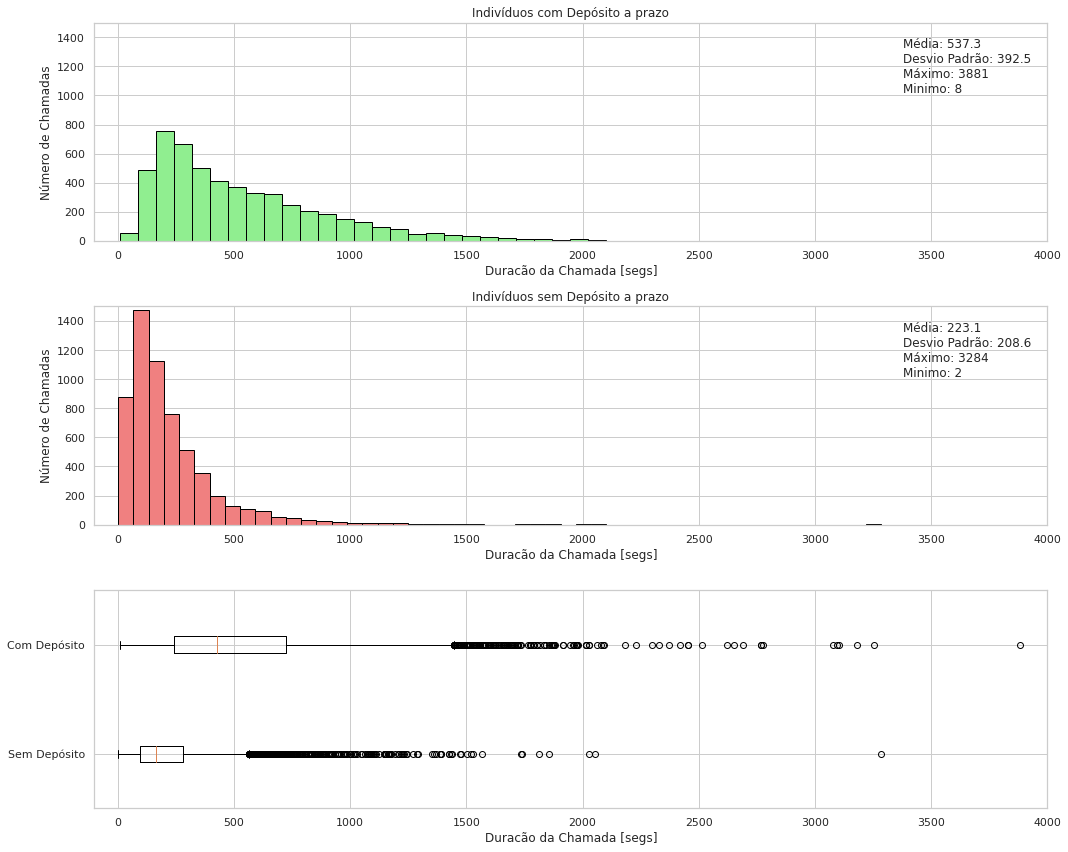

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))

ax1.hist(df_dep_yes['duration'], 50, edgecolor='black', color = "lightgreen")
media1 = np.round(df_dep_yes['duration'].mean(axis=0), 1)
dp1 = np.round(df_dep_yes['duration'].std(axis=0),1)
max1 = np.round(df_dep_yes['duration'].max(axis=0),1)
min1 = np.round(df_dep_yes['duration'].min(axis=0),1)
texto = f'Média: {media1}\nDesvio Padrão: {dp1}\nMáximo: {max1}\nMinimo: {min1}'
ax1.text(x = max1-500, y = 1000, s = texto, verticalalignment='bottom')
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set(xlabel='Duracão da Chamada [segs]', ylabel = 'Número de Chamadas')
ax1.set_ylim(0, 1500)
ax1.set_xlim(-100, 4000)

ax2.hist(df_dep_no['duration'], 50, edgecolor='black', color = "lightcoral")
media2 = np.round(df_dep_no['duration'].mean(axis=0), 1)
dp2 = np.round(df_dep_no['duration'].std(axis=0),1)
max2 = np.round(df_dep_no['duration'].max(axis=0),1)
min2 = np.round(df_dep_no['duration'].min(axis=0),1)
texto = f'Média: {media2}\nDesvio Padrão: {dp2}\nMáximo: {max2}\nMinimo: {min2} '
ax2.text(x = max1-500, y = 1000, s = texto, verticalalignment='bottom')
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set(xlabel='Duracão da Chamada [segs]', ylabel = 'Número de Chamadas')
ax2.set_ylim(0, 1500)
ax2.set_xlim(-100, 4000)

ax3.boxplot([df_dep_no['duration'],df_dep_yes['duration']], vert = False)
ax3.set(xlabel='Duracão da Chamada [segs]')
ax3.set_xlim(-100, 4000)
ax3.set_yticklabels(['Sem Depósito', 'Com Depósito'])

plt.tight_layout()

##### Campaign

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


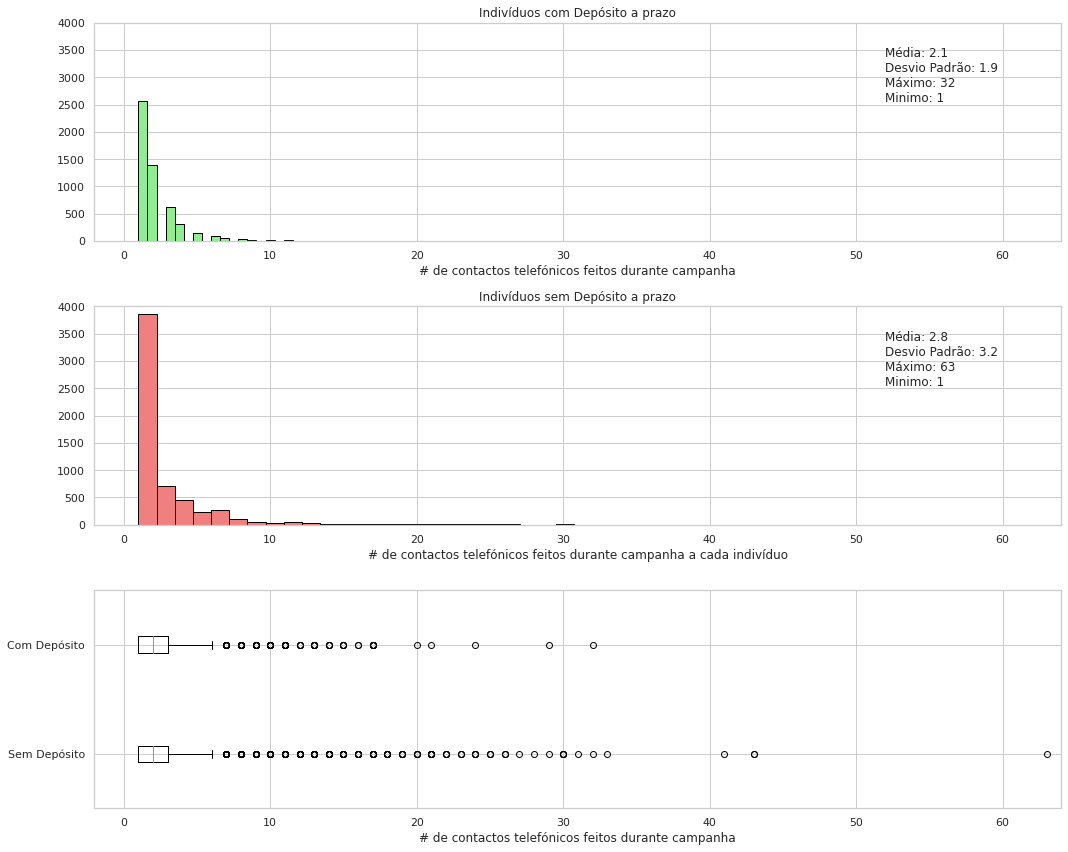

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))

ax1.hist(df_dep_yes['campaign'], 50, edgecolor='black', color = "lightgreen")
media1 = np.round(df_dep_yes['campaign'].mean(axis=0), 1)
dp1 = np.round(df_dep_yes['campaign'].std(axis=0),1)
max1 = np.round(df_dep_yes['campaign'].max(axis=0),1)
min1 = np.round(df_dep_yes['campaign'].min(axis=0),1)
texto = f'Média: {media1}\nDesvio Padrão: {dp1}\nMáximo: {max1}\nMinimo: {min1}'
ax1.text(x = max1+20, y = 2500, s = texto, verticalalignment='bottom')
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set(xlabel='# de contactos telefónicos feitos durante campanha')
ax1.set_ylim(0, 4000)
ax1.set_xlim(-2, 64 )

ax2.hist(df_dep_no['campaign'], 50, edgecolor='black', color = "lightcoral")
media2 = np.round(df_dep_no['campaign'].mean(axis=0), 1)
dp2 = np.round(df_dep_no['campaign'].std(axis=0),1)
max2 = np.round(df_dep_no['campaign'].max(axis=0),1)
min2 = np.round(df_dep_no['campaign'].min(axis=0),1)
texto = f'Média: {media2}\nDesvio Padrão: {dp2}\nMáximo: {max2}\nMinimo: {min2} '
ax2.text(x = max1+20, y = 2500, s = texto, verticalalignment='bottom')
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set(xlabel='# de contactos telefónicos feitos durante campanha a cada indivíduo')
ax2.set_ylim(0, 4000)
ax2.set_xlim(-2, 64 )

ax3.boxplot([df_dep_no['campaign'],df_dep_yes['campaign']], vert = False)
ax3.set(xlabel='# de contactos telefónicos feitos durante campanha')
ax3.set_xlim(-2, 64 )
ax3.set_yticklabels(['Sem Depósito', 'Com Depósito'])

plt.tight_layout()

In [ ]:
df_pd = df.toPandas()
for col in cols_qtt:
  print(pd.to_numeric(df_pd[col], errors='coerce').notnull().all())

True
True
True
True
True
True
True


#### 2.6.2 Variáveis Categóricas

##### Job

In [ ]:
df_job = df.groupby("job").count() 
df_job = df_job.withColumn('percentage', 
                           round(df_job['count']/df.count()*100, 1))\
                           .sort(desc("count")).show()

+-------------+-----+----------+
|          job|count|percentage|
+-------------+-----+----------+
|   management| 2566|      23.0|
|  blue-collar| 1944|      17.4|
|   technician| 1823|      16.3|
|       admin.| 1334|      12.0|
|     services|  923|       8.3|
|      retired|  778|       7.0|
|self-employed|  405|       3.6|
|      student|  360|       3.2|
|   unemployed|  357|       3.2|
| entrepreneur|  328|       2.9|
|    housemaid|  274|       2.5|
|      unknown|   70|       0.6|
+-------------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('job').size().keys().tolist()
val_yes = df_dep_yes.groupby('job').size().values.tolist()

In [ ]:
lab_no = df_dep_no.groupby('job').size().keys().tolist()
val_no = df_dep_no.groupby('job').size().values.tolist()

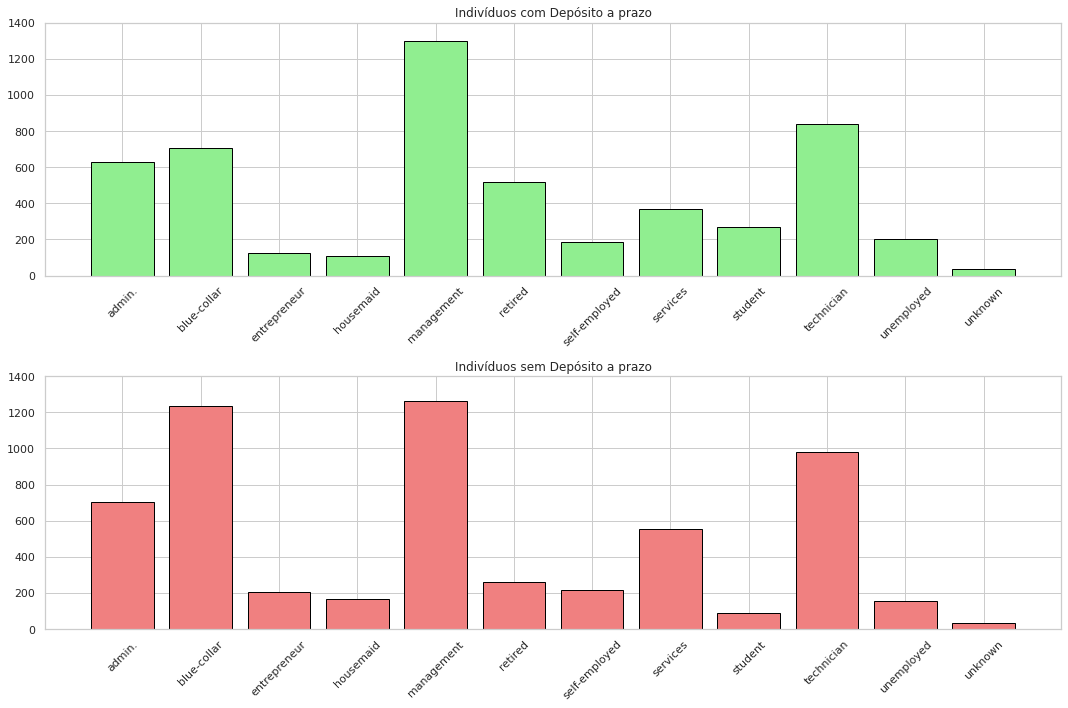

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,10))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_ylim(0, 1400)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_ylim(0, 1400)

plt.tight_layout()

In [ ]:
perc_dep = list()
for i in range(len(val_no)):
  sum = val_no[i] + val_yes[i]
  perc_dep.append((val_yes[i]/sum)*100)

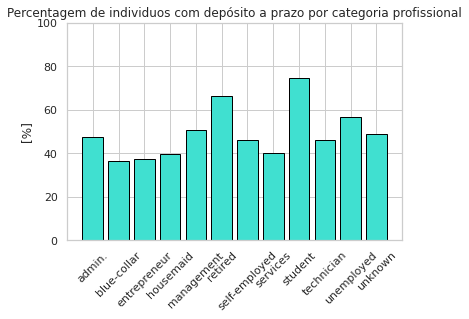

In [ ]:
plt.bar(lab_yes, perc_dep, edgecolor='black', color = 'turquoise')
plt.xticks(lab_yes, rotation = 45)
plt.ylabel('[%]')
plt.title('Percentagem de individuos com depósito a prazo por categoria profissional')
plt.ylim(0, 100)
plt.show()

##### Education




In [ ]:
df_temp = df.groupby("education").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+---------+-----+----------+
|education|count|percentage|
+---------+-----+----------+
|secondary| 5476|      49.1|
| tertiary| 3689|      33.0|
|  primary| 1500|      13.4|
|  unknown|  497|       4.5|
+---------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('education').size().keys().tolist()
val_yes = df_dep_yes.groupby('education').size().values.tolist()
lab_no = df_dep_no.groupby('education').size().keys().tolist()
val_no = df_dep_no.groupby('education').size().values.tolist()

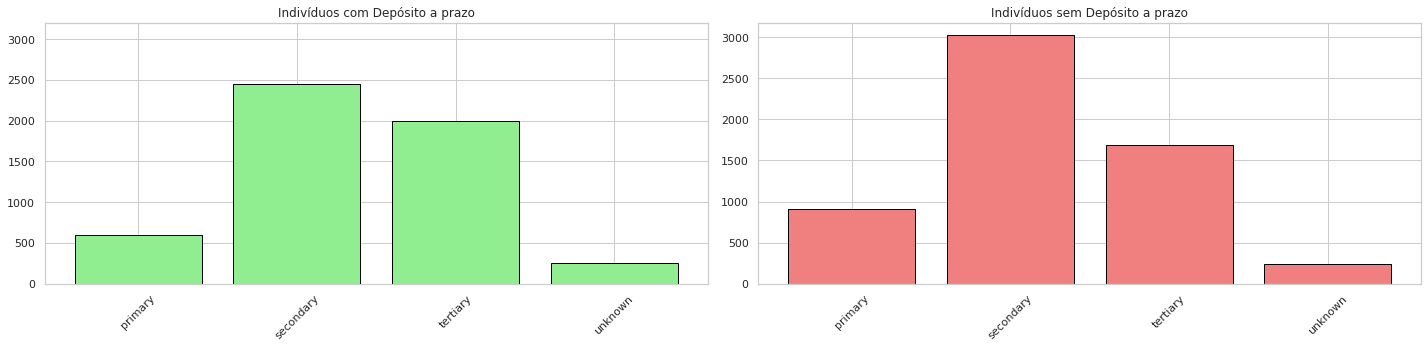

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_ylim(0, 3200)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax1.set_ylim(0, 3200)

plt.tight_layout()

##### Marital

In [ ]:
df_temp = df.groupby("marital").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()


+--------+-----+----------+
| marital|count|percentage|
+--------+-----+----------+
| married| 6351|      56.9|
|  single| 3518|      31.5|
|divorced| 1293|      11.6|
+--------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('marital').size().keys().tolist()
val_yes = df_dep_yes.groupby('marital').size().values.tolist()
lab_no = df_dep_no.groupby('marital').size().keys().tolist()
val_no = df_dep_no.groupby('marital').size().values.tolist()

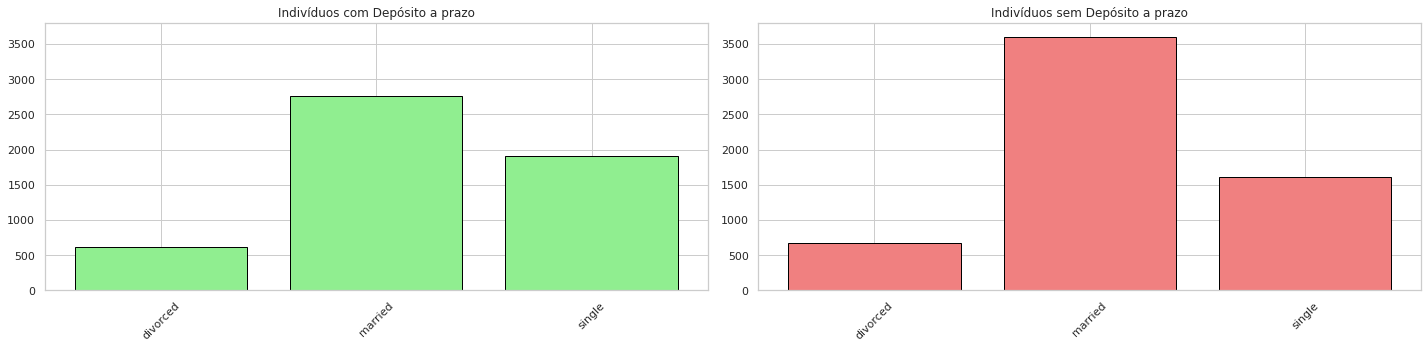

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_ylim(0, 3800)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_ylim(0, 3800)

plt.tight_layout()

##### Default

In [ ]:
df_temp = df.groupby("default").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+-------+-----+----------+
|default|count|percentage|
+-------+-----+----------+
|     no|10994|      98.5|
|    yes|  168|       1.5|
+-------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('default').size().keys().tolist()
val_yes = df_dep_yes.groupby('default').size().values.tolist()
lab_no = df_dep_no.groupby('default').size().keys().tolist()
val_no = df_dep_no.groupby('default').size().values.tolist()

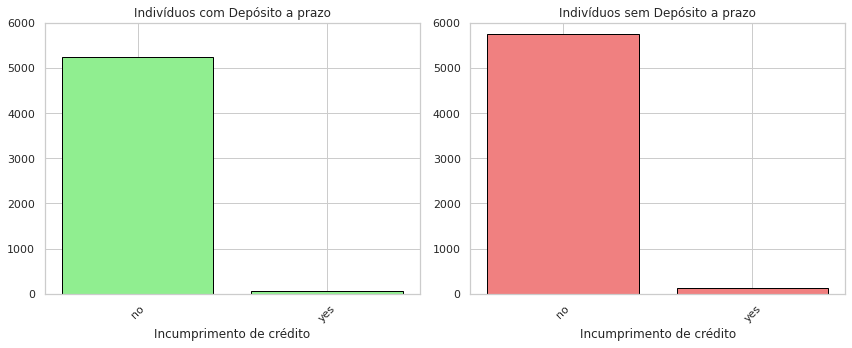

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_xlabel('Incumprimento de crédito')
ax1.set_ylim(0, 6000)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_ylim(0, 6000)
ax2.set_xlabel('Incumprimento de crédito')

plt.tight_layout()

##### Housing

In [ ]:
df_temp = df.groupby("housing").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+-------+-----+----------+
|housing|count|percentage|
+-------+-----+----------+
|     no| 5881|      52.7|
|    yes| 5281|      47.3|
+-------+-----+----------+



##### Loan

In [ ]:
df_temp = df.groupby("loan").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+----+-----+----------+
|loan|count|percentage|
+----+-----+----------+
|  no| 9702|      86.9|
| yes| 1460|      13.1|
+----+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('loan').size().keys().tolist()
val_yes = df_dep_yes.groupby('loan').size().values.tolist()
lab_no = df_dep_no.groupby('loan').size().keys().tolist()
val_no = df_dep_no.groupby('loan').size().values.tolist()

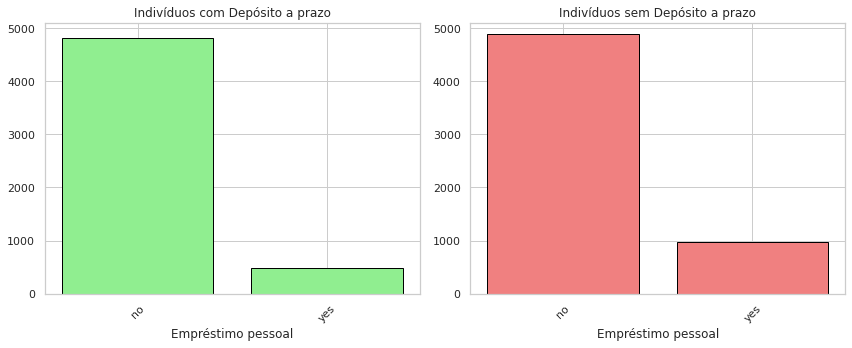

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_xlabel('Empréstimo pessoal')
ax1.set_ylim(0, 5100)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_ylim(0, 5100)
ax2.set_xlabel('Empréstimo pessoal')

plt.tight_layout()

##### Contact

In [ ]:
df_temp = df.groupby("contact").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+---------+-----+----------+
|  contact|count|percentage|
+---------+-----+----------+
| cellular| 8042|      72.0|
|  unknown| 2346|      21.0|
|telephone|  774|       6.9|
+---------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('contact').size().keys().tolist()
val_yes = df_dep_yes.groupby('contact').size().values.tolist()
lab_no = df_dep_no.groupby('contact').size().keys().tolist()
val_no = df_dep_no.groupby('contact').size().values.tolist()

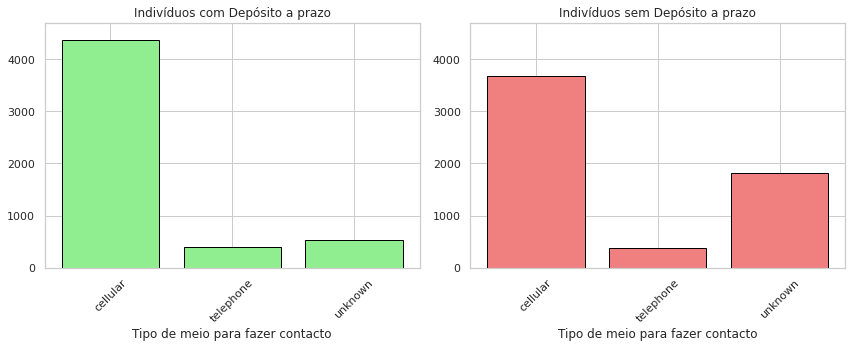

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_xlabel('Tipo de meio para fazer contacto')
ax1.set_ylim(0, 4700)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_xlabel('Tipo de meio para fazer contacto')
ax2.set_ylim(0, 4700)

plt.tight_layout()

##### Poutcome

In [ ]:
df_temp = df.groupby("poutcome").count() 
df_temp.withColumn('percentage', 
                   round(df_temp['count']/df.count()*100, 1))\
                   .sort(desc("count")).show()

+--------+-----+----------+
|poutcome|count|percentage|
+--------+-----+----------+
| unknown| 8326|      74.6|
| failure| 1228|      11.0|
| success| 1071|       9.6|
|   other|  537|       4.8|
+--------+-----+----------+



In [ ]:
lab_yes = df_dep_yes.groupby('poutcome').size().keys().tolist()
val_yes = df_dep_yes.groupby('poutcome').size().values.tolist()
lab_no = df_dep_no.groupby('poutcome').size().keys().tolist()
val_no = df_dep_no.groupby('poutcome').size().values.tolist()

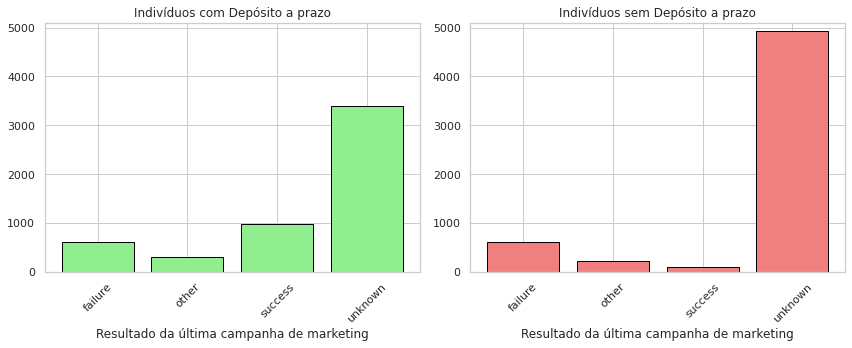

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.bar(lab_yes, val_yes, edgecolor='black', color = "lightgreen")
ax1.set_xticklabels(lab_yes, rotation = 45)
ax1.set_title('Indivíduos com Depósito a prazo')
ax1.set_xlabel('Resultado da última campanha de marketing')
ax1.set_ylim(0, 5100)

ax2.bar(lab_no, val_no, edgecolor='black', color = "lightcoral")
ax2.set_xticklabels(lab_no, rotation = 45)
ax2.set_title('Indivíduos sem Depósito a prazo')
ax2.set_xlabel('Resultado da última campanha de marketing')
ax2.set_ylim(0, 5100)

plt.tight_layout()

In [ ]:
perc_dep = list()
for i in range(len(val_no)):
  sum = val_no[i] + val_yes[i]
  perc_dep.append((val_yes[i]/sum)*100)

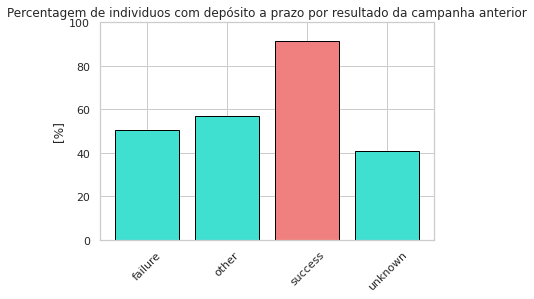

In [ ]:
plt.bar(lab_yes, perc_dep, edgecolor='black', color = ["turquoise", "turquoise","lightcoral","turquoise"])
plt.xticks(lab_yes, rotation = 45)
plt.ylabel('[%]')
plt.title('Percentagem de individuos com depósito a prazo por resultado da campanha anterior')
plt.ylim(0, 100)
plt.show()

In [ ]:
print(f'Dentro do grupo que aderiu (success) à campanha anterior, {np.round(perc_dep[2],1)} % voltou a aderir a esta nova campanha.')

Dentro do grupo que aderiu (success) à campanha anterior, 91.3 % voltou a aderir a esta nova campanha.


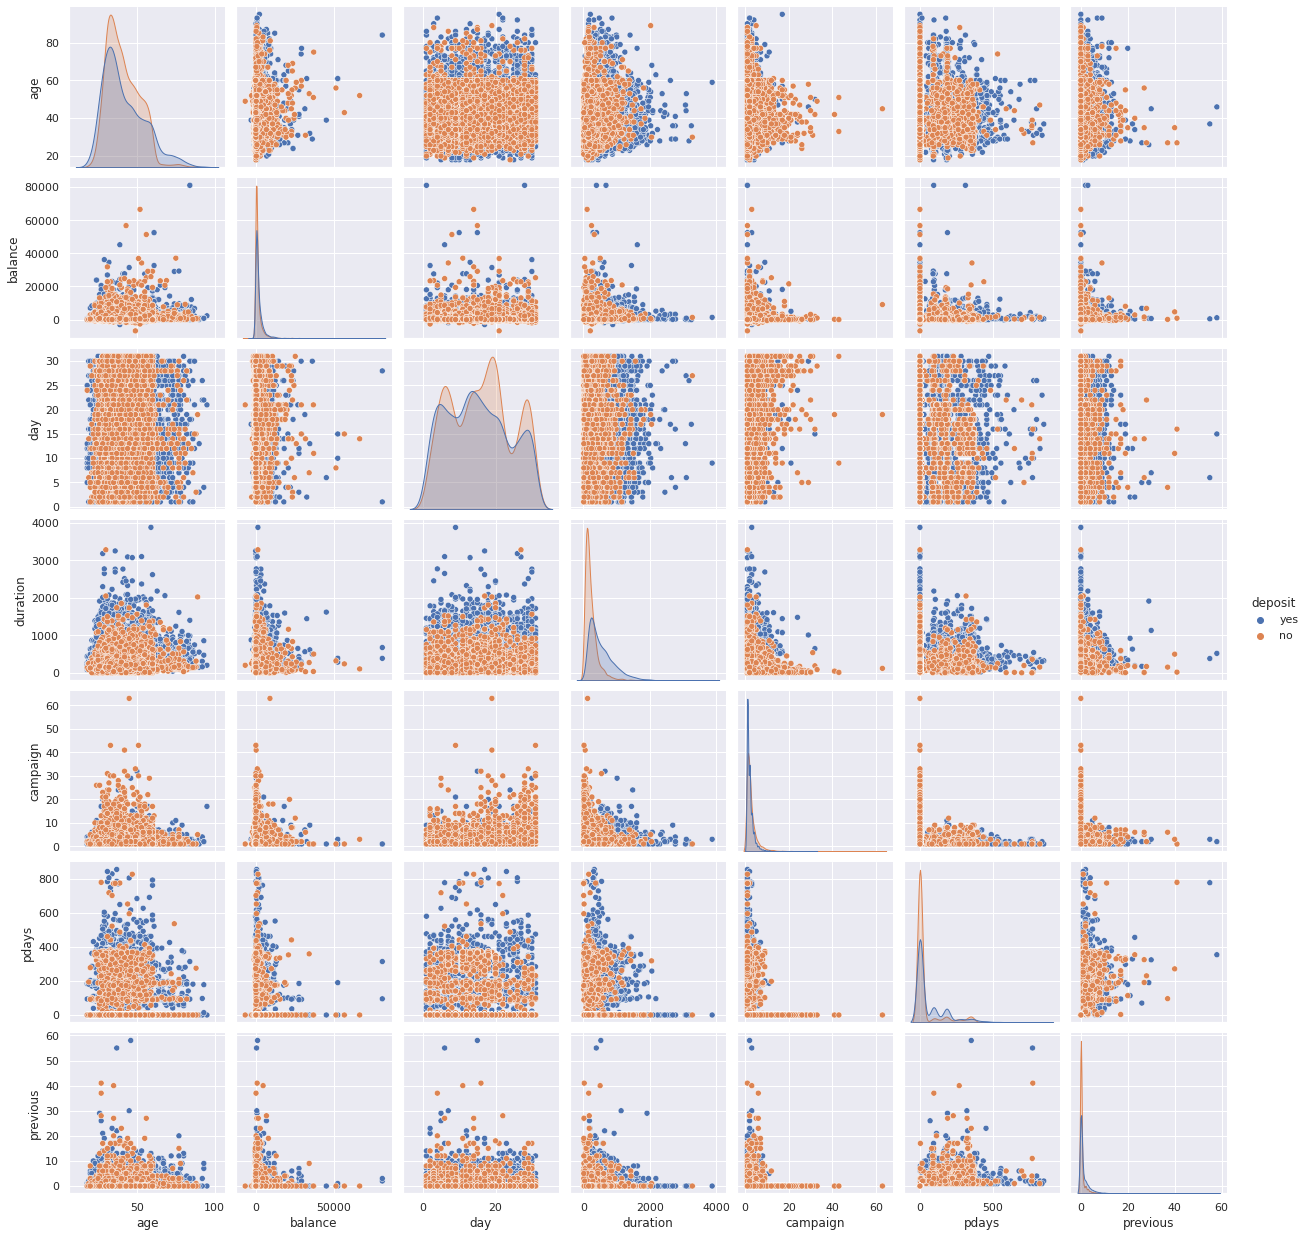

In [ ]:
df_pd = df.toPandas()
sns.set(rc = {'figure.figsize':(15,17)})
sns.pairplot(df_pd, hue="deposit")
plt.show()

### 2.7 Correlacão da Variáveis Numéricas



In [ ]:
df_pd.deposit = df_pd.deposit.map({'yes':1, 'no': 0})

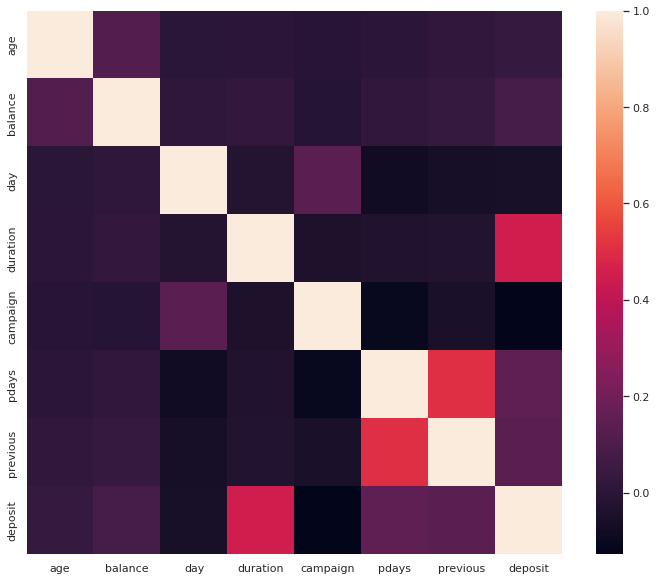

In [ ]:
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(df_pd.corr('pearson'))
plt.show()

In [ ]:
df_pd.corr('pearson')

,age,balance,day,duration,campaign,pdays,previous,deposit
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169,0.034901
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805,0.081129
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981,-0.056326
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716,0.451919
campaign,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699,-0.128081
pdays,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272,0.151593
previous,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000,0.139867
deposit,0.034901,0.081129,-0.056326,0.451919,-0.128081,0.151593,0.139867,1.000000


## 3. Preparacão dos Dados

### 3.1 Selecão de variáveis



Comentário do autor do conjunto de dados (https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)


> **duration**: duração do último contacto, em segundos (numéricos).

> **Nota importante**: este atributo afecta fortemente a variável alvo de saída (por exemplo, se duração=0 então y='não'). No entanto, a duração não é conhecida antes da realização de uma chamada. Além disso, após o fim da chamada y é obviamente conhecida. Assim, esta entrada só deve ser incluída para fins de referência e deve ser descartada se a intenção for ter um modelo de previsão realista.

In [ ]:
df = df.drop('duration')       # exclui coluna 'duration'



### 3.2 Transformacão dos Dados

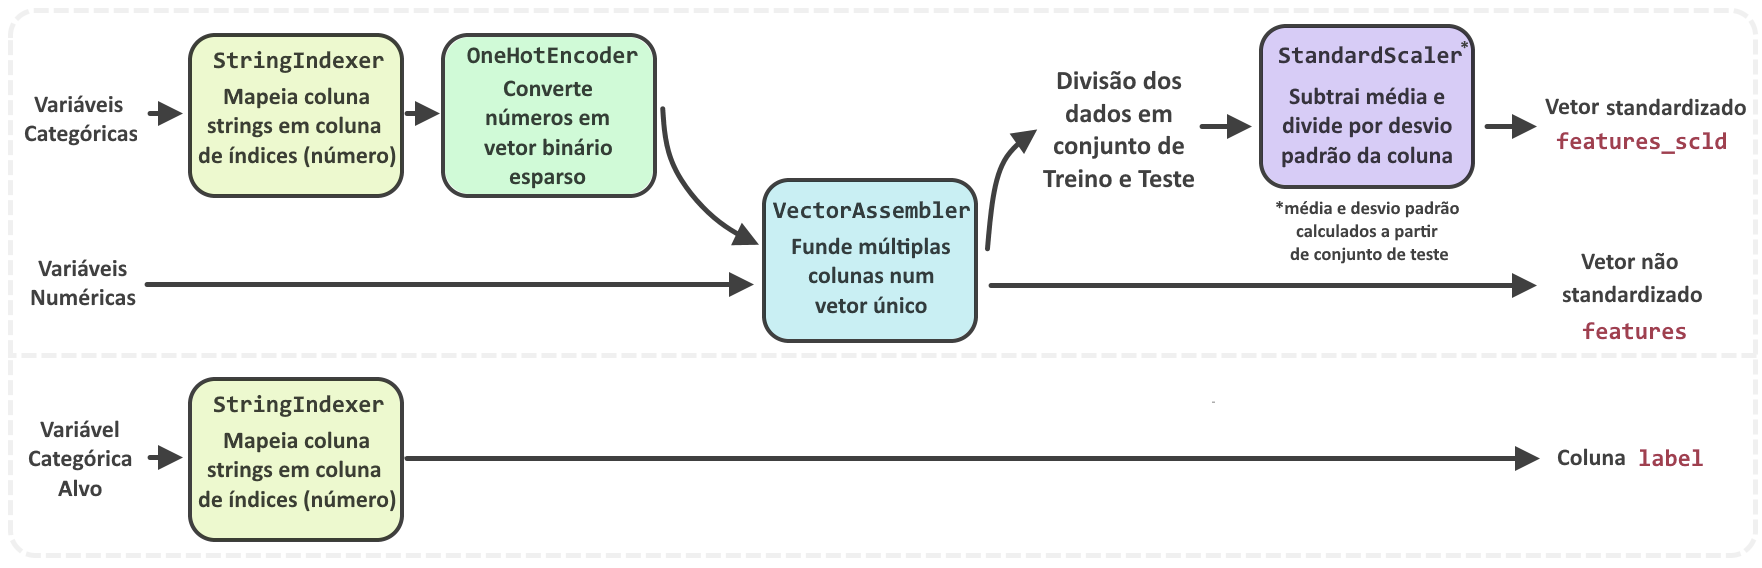

#### 3.2.1 Variáveis Categóricas

> **StringIndexer** codifica coluna categórica numa coluna numérica \\
> **OneHotEncoder** converte coluna numerica em coluna binária one-hot

In [ ]:
# Lista de colunas categóricas
cols_categoricas = ['job', 'marital', 'education', 'default', 'housing', 
                    'loan', 'contact', 'poutcome', 'month']

# Lista vazia para armazenar as etapas do pipeline
pipeline_lista = list()
colunas_one_hot = list()
# Loop pelas colunas categóricas
for coluna in cols_categoricas:
    # Cria um objeto StringIndexer para cada coluna
    string_indexer = StringIndexer(inputCol=coluna, outputCol=coluna + '_numeric')
    # Adiciona o indexador à lista de etapas
    pipeline_lista.append(string_indexer)
    # Cria um objeto OneHotEncoder para cada coluna
    one_encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], 
                                outputCols=[coluna + '_onehot'])
    colunas_one_hot.append(coluna + '_onehot')
    # Adiciona o codificador à lista de etapas
    pipeline_lista.append(one_encoder)

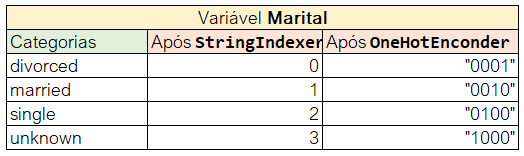

##### 3.2.1.1 Variáveis Categórica Alvo **'deposit'** 
> **StringIndexer** codifica coluna categórica numa coluna numérica 



In [ ]:
# Cria um objeto StringIndexer para a coluna 'deposit'
label_indexer = StringIndexer(inputCol='deposit', outputCol='label')
# Adiciona o indexador à lista de etapas
pipeline_lista.append(label_indexer)

#### 3.2.1 Variáveis Numéricas


In [ ]:
# Lista de colunas numéricas
cols_numericas = ['age', 'balance', 'campaign', 'pdays', 'previous']

As Variáveis de Entrada são vetorizadas

> **VectorAssembler**  funde múltiplas colunas numa coluna vectorial

> **Preditores têm de ficar no mesma coluna do tipo VETOR ('features') no Spark!** 


In [ ]:
vetorizador = VectorAssembler(inputCols = cols_numericas +  colunas_one_hot, outputCol = 'features')
pipeline_lista.append(vetorizador)

In [ ]:
pipeline = Pipeline(stages=pipeline_lista)

In [ ]:
# Aplica o pipeline ao conjunto de dados de entrada
df = pipeline.fit(df).transform(df)

### 3.3 Divisão de Dados 

<table>
<thead>
  <tr>
    <th colspan="3"> </th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Treino/Validacão </td>
    <td>| 8998 registos </td>
    <td>| 80 % </td>
  </tr>
  <tr>
    <td>Teste </td>
    <td>| 2164 registos <br></td>
    <td>| 20 % </td>
  </tr>
  <tr>
    <td><strong>Total </strong></td>
    <td>| 11162 registos </td>
    <td>|<strong> 100 % </strong> </td>
  </tr>
</tbody>
</table>

In [ ]:
treino, teste = df.randomSplit([0.8, 0.2], seed=42)

> **StandardScaler** normaliza as variáveis de modo a terem desvio padrão unitário e/ou média zero

In [ ]:
normalizador = StandardScaler(inputCol='features', outputCol= 'features_scld')
modelo_norm = normalizador.fit(treino)

In [ ]:
treino = modelo_norm.transform(treino)

In [ ]:
teste = modelo_norm.transform(teste)

In [ ]:
treino.select("features","features_scld", "label").show(truncate = False)

+----------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                  |features_scld                                                                                                                                                                                                                                                                                                       |label|
+----------------------------------------------------------------------------------------------------------+--------------------------------------------

In [ ]:
print(f'# conjunto de treino: {treino.count()} registos\n# conjunto de teste: {teste.count()} registos')

# conjunto de treino: 8998 registos
# conjunto de teste: 2164 registos


## 4. Modelacão e Avaliacão

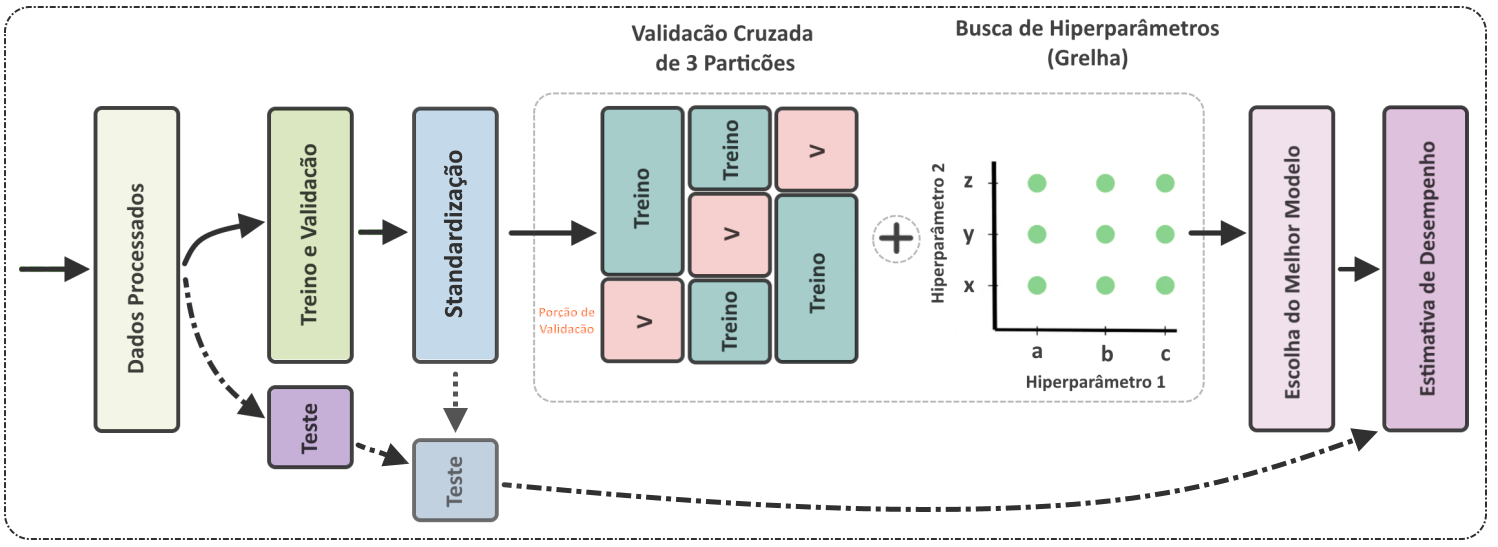

In [ ]:
def calcula_metricas(nome_modelo, ground_truth, predicao):
  """
    Funcão Auxiliar para calcular e imprimir métricas: Tx de Acerto, F1, 
    Precisão, Sensibilidade e AUC
  """
  acc = accuracy_score(y_true = ground_truth, y_pred = predicao)
  f1 = f1_score(y_true = ground_truth, y_pred = predicao)
  precision = precision_score(y_true = ground_truth, y_pred = predicao)
  recall = recall_score(y_true = ground_truth, y_pred = predicao)
  auc_sklearn = roc_auc_score(y_true = ground_truth, y_score = predicao)

  print(f"Desempenho {nome_modelo} - Conjunto de Teste")
  print(f' Taxa de Acerto: {np.round(acc*100,2)}%\n Precisão: {np.round(precision*100,2)}%')
  print(f' Sensibilidade: {np.round(recall*100,2)}%\n Medida F1: {np.round(f1*100,2)}%')
  print(f' Área sob a Curva: {np.round(auc_sklearn*100,2)}%')

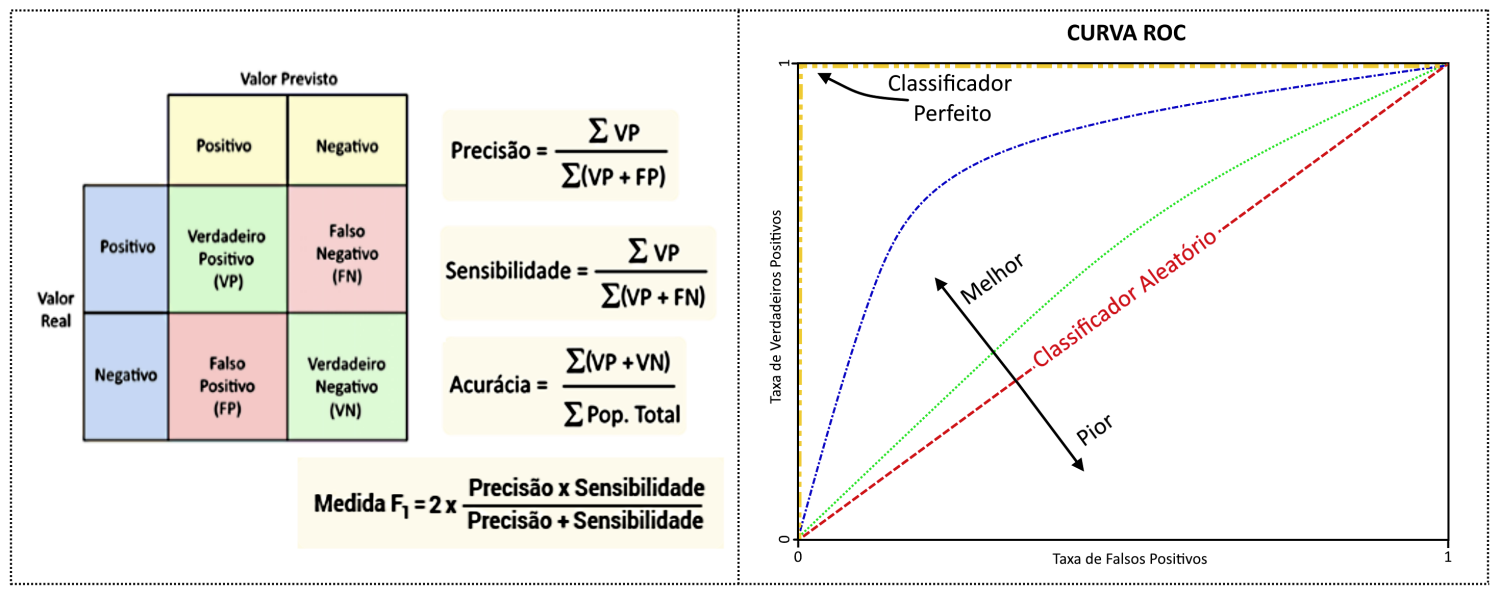

In [ ]:
def gera_predicoes(modelo, dados_teste):
  """
    Funcão Auxiliar para gerar predicao do modelo.
    Devolve predicao e ground_truth (label)
  """
  predicao_target = modelo.transform(dados_teste).select("label", "prediction")
  predicao_target_np = np.array((predicao_target.collect()))
  ground_truth = predicao_target_np[:,0]
  predicao = predicao_target_np[:,1]

  return ground_truth, predicao

### 4.1 Regressão Logística

In [ ]:
# Cria o modelo de Regressão Logística
lr = LogisticRegression(featuresCol='features_scld', labelCol='label')

# Gera grelha de busca de parametros
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0, 0.25,  0.5, 0.75, 1]) \
    .addGrid(lr.regParam, [1, 0.1,  0.01, 0.001]) \
    .build()

# Validacão Cruzada 
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator= BinaryClassificationEvaluator(),
                          numFolds=3) 

# Treina modelo com Validacao Cruzada k=3
inicio = time.time() 
cvModel_lr = crossval.fit(treino)
treino_temp = time.time() - inicio

# Extrai melhor modelo 
bestModel_lr = cvModel_lr.bestModel

# Gera Predicões
ground_truth, pred_lr = gera_predicoes(bestModel_lr, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('Regressão Logística', ground_truth, pred_lr)

print(f'\n Tempo de treino: {np.round(treino_temp/60,2)} minutos')

Desempenho Regressão Logística - Conjunto de Teste
 Taxa de Acerto: 70.98%
 Precisão: 73.68%
 Sensibilidade: 59.13%
 Medida F1: 65.61%
 Área sob a Curva: 70.27%

 Tempo de treino: 2.27 minutos


### 4.2 Árvore de Decisão 

In [ ]:
# Cria modelo de Arvores de Decisão
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Gera Grelha de Busca de Parametros (para Val. Cruzada)
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2,3, 4, 5])
             .addGrid(dt.maxBins, [4, 8, 16, 32, 64])
             .build())

# Cria "Validador Cruzado" 
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3) 

# Treina modelo com Validacao Cruzada k=3
inicio = time.time() 
cvModel_dt = crossval.fit(treino)
treino_temp = time.time() - inicio 

# Extrai melhor modelo 
bestModel_dt = cvModel_dt.bestModel

# Gera Predicões
ground_truth, pred_dt = gera_predicoes(bestModel_dt, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('Arvore de Decisão', ground_truth, pred_dt)

print(f'\n Tempo de treino: {np.round(treino_temp/60,2)} minutos')

Desempenho Arvore de Decisão - Conjunto de Teste
 Taxa de Acerto: 66.96%
 Precisão: 66.86%
 Sensibilidade: 58.34%
 Medida F1: 62.31%
 Área sob a Curva: 66.44%

 Tempo de treino: 0.67 minutos


###  4.3 Floresta Aleatória

In [ ]:
# Cria o modelo de Floresta Aleatória
rf = RandomForestClassifier(labelCol="label", featuresCol="features_scld")

# Gera grelha de busca de parametros
paramGrid = ParamGridBuilder() \
             .addGrid(rf.maxBins, [16, 32]) \
             .addGrid(rf.numTrees, [20, 30, 40]) \
             .build()

# Validacão Cruzada 
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator= BinaryClassificationEvaluator(),
                          numFolds=3) 

# Treina modelo com Validacao Cruzada k=3 
inicio = time.time()
cvModel_rf = crossval.fit(treino)
treino_temp = time.time() - inicio

# Extrai melhor modelo
bestModel_rf = cvModel_rf.bestModel

# Gera Predicões
ground_truth, pred_rf = gera_predicoes(bestModel_rf, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('Floresta Aleatória', ground_truth, pred_rf)

print(f'\n Tempo de treino: {np.round(treino_temp/60,2)} minutos')

Desempenho Floresta Aleatória - Conjunto de Teste
 Taxa de Acerto: 70.33%
 Precisão: 75.1%
 Sensibilidade: 54.79%
 Medida F1: 63.36%
 Área sob a Curva: 69.4%

 Tempo de treino: 0.42 minutos


In [ ]:
#print(rf.explainParams())

### 4.4 *Gradient Boosting* em Árvore

In [ ]:
# Cria o modelo de Gradient Boosting
gbt = GBTClassifier(labelCol="label", featuresCol="features_scld", maxIter=50)

# Gera grelha de busca de parametros
paramGrid = ParamGridBuilder() \
             .addGrid(gbt.maxDepth, [8, 16]) \
             .build()

# Validacão Cruzada 
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator= BinaryClassificationEvaluator(),
                          numFolds=3) 

# Treina modelo com Validacao Cruzada k=3 
inicio = time.time() 
cvModel_gbt = crossval.fit(treino)
treino_temp = time.time() - inicio

# Extrai melhor modelo
bestModel_gbt = cvModel_gbt.bestModel

# Gera Predicões
ground_truth, pred_gbt = gera_predicoes(bestModel_gbt, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('Gradient Boosting em Árvore', ground_truth, pred_gbt)

print(f'\n Tempo de treino: {np.round(treino_temp/60,2)} minutos')

Desempenho Gradient Boosting em Árvore - Conjunto de Teste
 Taxa de Acerto: 71.9%
 Precisão: 73.85%
 Sensibilidade: 61.9%
 Medida F1: 67.35%
 Área sob a Curva: 71.3%

 Tempo de treino: 13.3 minutos


### 4.5 Perceptrão Multicamada

In [ ]:
# Camadas do Perceptrão Multicamada
#   - entrada: 40 (dimensão features)
#   - 2 camadas ocultas: 80, 40
#   - saida: 2 (classificacao binária)
camadas = [40, 80, 40, 2]

# Cria modelo de Perceptrão Multicamada
mlp = MultilayerPerceptronClassifier(labelCol='label',
                                     featuresCol='features_scld',
                                     maxIter= 5000, 
                                     layers=camadas, 
                                     blockSize = 16,
                                     solver = 'gd', 
                                     seed=42)

# Gera Grelha de Busca de Parametros (para Val. Cruzada)
paramGrid = ParamGridBuilder() \
    .addGrid(mlp.stepSize, [1, 0.1,  0.01]) \
    .build()

# Criar "Validador Cruzado" com 3 Particões 
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator= BinaryClassificationEvaluator(),
                          numFolds=3)

# Treina modelo com Validacao Cruzada k=3
inicio = time.time() 
cvModel_mlp = crossval.fit(treino)
treino_temp = time.time() - inicio 


# Extrai melhor modelo 
bestModel_mlp = cvModel_mlp.bestModel

# Gera Predicões
ground_truth, pred_mlp = gera_predicoes(bestModel_mlp, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('Perceptrão Multicamada', ground_truth, pred_mlp)

print(f'\n Tempo de treino: {np.round(treino_temp/60,2)} minutos')

Desempenho Perceptrão Multicamada - Conjunto de Teste
 Taxa de Acerto: 71.72%
 Precisão: 74.24%
 Sensibilidade: 60.61%
 Medida F1: 66.74%
 Área sob a Curva: 71.05%

 Tempo de treino: 52.12 minutos


### 4.6 Máquinas de Suporte de Vetores (SVM)

In [ ]:
# Cria o classificador SVM
svm = LinearSVC(featuresCol='features_scld', labelCol='label', maxIter=100)

# Gera Grelha de Busca de Parametros (para Val. Cruzada)
paramGrid = ParamGridBuilder() \
    .addGrid(svm.aggregationDepth, [2, 3]) \
    .addGrid(svm.regParam, [1, 2,  3, 4]) \
    .build()

# Criar Validador Cruzado com 3 Particões 
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator= BinaryClassificationEvaluator(),
                          numFolds=3) 

# Treina modelo com Validacao Cruzada k=3
inicio = time.time() 
cvModel_svm = crossval.fit(treino)
treino_temp = time.time() - inicio 

# Extrai melhor modelo 
bestModel_svm = cvModel_svm.bestModel

# Gera Predicões
ground_truth, pred_svm = gera_predicoes(bestModel_svm, teste)

In [ ]:
# Calcula Métricas
calcula_metricas('SVM', ground_truth, pred_svm)

print(f'\n Tempo de treino: {np.round(treino_temp/60, 2)} minutos')

Desempenho SVM - Conjunto de Teste
 Taxa de Acerto: 67.74%
 Precisão: 75.36%
 Sensibilidade: 46.2%
 Medida F1: 57.28%
 Área sob a Curva: 66.45%

 Tempo de treino: 1.58 minutos


## 5. Resultados

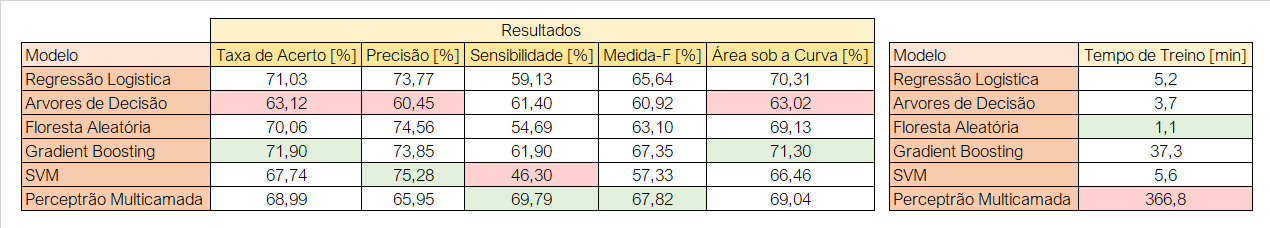

Para o problema em questão, queremos algoritmos com maior Precisão (+ Verdadeiros Positivos). Para mover algoritmos no sentido de mais Precisão, pode-se ajustar (aumentar) o limiar de decisão.

In [ ]:
spark.stop()

## Fim de Script